<a href="https://colab.research.google.com/github/Monsurat-Onabajo/DeepLearning_projects/blob/main/Brain_Tumor_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import requests
from PIL import Image
import os
from pathlib import Path
import zipfile
import torchvision

In [ ]:
# making a kaggle directory and adding it to the root directory folder
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


## Before you run this cell, ensure the kaggle.json file which will contain the kaggle token has been imported manually into the kaggle folder

In [ ]:
# my kaggle token has been imported into the kaggle folder manually and i can now import kaggle
import kaggle

# this code will ensure that my api key is save
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
kaggle.api.authenticate()

In [ ]:
!kaggle datasets download -d iashiqul/brain-tumor-mri-image-classification -p data_path

brain-tumor-mri-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
with zipfile.ZipFile('/content/data_path/brain-tumor-mri-image-classification.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/data_path/brain-tumor-mri-image-classification')


In [ ]:
image_path=Path('/content/data_path/brain-tumor-mri-image-classification/Brain Tumor MRI Classfication')
test_dir= Path('/content/data_path/brain-tumor-mri-image-classification/Brain Tumor MRI Classfication/Testing')
train_dir= Path('/content/data_path/brain-tumor-mri-image-classification/Brain Tumor MRI Classfication/Training')
val_dir= Path('/content/data_path/brain-tumor-mri-image-classification/Brain Tumor MRI Classfication/Validation')


exploring the data

In [ ]:
def walkthrough_dir(dir_path):
  '''
  walks through a dir path 
  returning its content'''
  for dirpath, dirname,filenames in os.walk(dir_path):
    print (f'there are {len(dirname)} directories and {len(filenames)} images in {dirpath}')
    

In [ ]:
image_path

PosixPath('/content/data_path/brain-tumor-mri-image-classification/Brain Tumor MRI Classfication')

In [ ]:
walkthrough_dir(image_path)

there are 3 directories and 0 images in /content/data_path/brain-tumor-mri-image-classification/Brain Tumor MRI Classfication
there are 4 directories and 0 images in /content/data_path/brain-tumor-mri-image-classification/Brain Tumor MRI Classfication/Validation
there are 0 directories and 38 images in /content/data_path/brain-tumor-mri-image-classification/Brain Tumor MRI Classfication/Validation/no_tumor
there are 0 directories and 52 images in /content/data_path/brain-tumor-mri-image-classification/Brain Tumor MRI Classfication/Validation/glioma_tumor
there are 0 directories and 53 images in /content/data_path/brain-tumor-mri-image-classification/Brain Tumor MRI Classfication/Validation/meningioma_tumor
there are 0 directories and 36 images in /content/data_path/brain-tumor-mri-image-classification/Brain Tumor MRI Classfication/Validation/pituitary_tumor
there are 4 directories and 0 images in /content/data_path/brain-tumor-mri-image-classification/Brain Tumor MRI Classfication/Test

# there is class imbalance in the training dataset

In [ ]:
train_dir

PosixPath('/content/data_path/brain-tumor-mri-image-classification/Brain Tumor MRI Classfication/Training')

In [ ]:
image_path

PosixPath('/content/data_path/brain-tumor-mri-image-classification/Brain Tumor MRI Classfication')

In [ ]:
import glob
data_list= list(image_path.glob(pattern= '*/*/*.jpg'))
train_data_list= list(train_dir.glob(pattern= '*/*.jpg'))
val_data_list= list(val_dir.glob(pattern= '*/*.jpg'))
test_data_list= list(test_dir.glob(pattern= '*/*.jpg'))

In [ ]:
total_data_length= len(data_list)
train_data_length= len(train_data_list)
test_data_length= len(test_data_list)
val_data_length= len(val_data_list)
a= f'The data are distributed as follow:\nThe length of the whole data is: {total_data_length}\nThe length of training data is {train_data_length}'
b= f'\nThe length of testing data is: {test_data_length}\nThe length of validation data is {val_data_length} '
print (a+b)

The data are distributed as follow:
The length of the whole data is: 3443
The length of training data is 2870
The length of testing data is: 394
The length of validation data is 179 


# the data is enough for training even though there is class imbalance in the training dataset. 
* check for duplicated values

In [ ]:
len(train_data_list), len(set(train_data_list))

(2870, 2870)

Random image path: /content/data_path/brain-tumor-mri-image-classification/Brain Tumor MRI Classfication/Training/no_tumor/image(43).jpg
image class: no_tumor
image height: 236
image width: 236


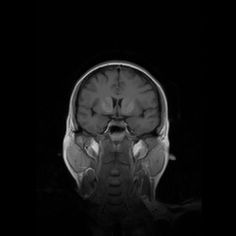

In [ ]:
# there is no duplicated image in our dataset. now viewing an image and making a function to view image later on
import random
random_= random.choice(data_list)
img= Image.open(random_)
image_class= random_.parent.stem
print (f'Random image path: {random_}')
print (f'image class: {image_class}')
print (f'image height: {img.height}')
print (f'image width: {img.width}')
img

turning the image into dataloaders using function

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def dataloader_function(train_dir, test_dir, val_dir, transform, batchsize, num_worker):
  'This function takes in an image path and return the transformed image data in batches'

  test_val_transform= transforms.Compose([
      transforms.Resize(size= (224,224)),
      transforms.ToTensor(),
      transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225]
          ),
  ])

  train_data= datasets.ImageFolder(train_dir, transform)
  test_data= datasets.ImageFolder(test_dir, transform= test_val_transform)
  val_data= datasets.ImageFolder(val_dir, test_val_transform)
  class_names= train_data.classes


  train_dataloader= DataLoader(dataset= train_data, batch_size= batchsize, shuffle= True, num_workers=num_worker)
  test_dataloader= DataLoader(dataset= test_data, batch_size= batchsize, shuffle= False, num_workers=num_worker)
  val_dataloader= DataLoader(dataset= val_data, batch_size= batchsize, shuffle= False, num_workers=num_worker)

  return train_dataloader, test_dataloader, val_dataloader, class_names

In [ ]:
weights= torchvision.models.EfficientNet_B0_Weights.DEFAULT
dir(weights)

['__class__',
 '__doc__',
 '__module__',
 'get_state_dict',
 'meta',
 'name',
 'transforms',
 'url',
 'value',
 'verify']

In [ ]:
transform= weights.transforms()
transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
test_dir

PosixPath('/content/data_path/brain-tumor-mri-image-classification/Brain Tumor MRI Classfication/Testing')

In [ ]:
train_dataloader, test_dataloader, val_dataloader, class_names= dataloader_function(test_dir= test_dir,
                                                                                    train_dir= train_dir, 
                                                                                    transform= transform, 
                                                                                    val_dir= val_dir,
                                                                                    batchsize=32,
                                                                                    num_worker=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
train_dataloader, test_dataloader, val_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fc6e4806ef0>,
 ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

In [ ]:
data, label= (next(iter(train_dataloader)))

In [ ]:
label

tensor([3, 2, 2, 2, 2, 2, 3, 2, 1, 0, 0, 1, 2, 3, 0, 3, 2, 1, 0, 0, 0, 0, 2, 1,
        1, 1, 0, 0, 2, 1, 2, 3])

In [ ]:
data[1].shape

torch.Size([3, 224, 224])

# setting up a pretrained model

In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
weights= torchvision.models.EfficientNet_B0_Weights.DEFAULT
model= torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchinfo import summary

summary(model= model,
        input_size= (1,3,600,600), # example of size of data we want to pass into our model
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings= ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 600, 600]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 600, 600]     [1, 1280, 19, 19]    --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 600, 600]     [1, 32, 300, 300]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 600, 600]     [1, 32, 300, 300]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 300, 300]    [1, 32, 300, 300]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 300, 300]    [1, 32, 300, 300]    --                   --
│    └─Sequential (1)                                        [1, 32, 300, 300]    [1, 16, 300,

In [ ]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [ ]:
# freeze all base layers in the efficientnetb0 model. (baselayer is model.features)
for params in model.features.parameters():
  params.requires_grad= False

In [ ]:
summary(model= model,
        input_size= (1,3,224,224), # example of size of data we want to pass into our model
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings= ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
from torch import nn

In [ ]:
model.classifier= nn.Sequential(
    nn.Dropout(p=0.5, inplace= True),
    nn.Linear(in_features= 1280, out_features= len(class_names), bias= True)

).to(device)

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=1280, out_features=4, bias=True)
)

In [ ]:
# freeze all base layers in the efficientnetb0 model. (baselayer is model.features)
for params in model.features.parameters():
  params.requires_grad= True

In [ ]:
summary(model= model,
        input_size= (1,3,224,224), # example of size of data we want to pass into our model
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings= ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 4]               --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [ ]:
# Training model
def train_loop(train_dataloader, model, loss_fn, optimizer, device):
  loss= 0
  accuracy=0

  model.train()
  for batchsize, (X, y) in enumerate(train_dataloader):
    X, y= X.to(device), y.to(device)
    y_logits= model(X)
    train_loss= loss_fn(y_logits, y)
    loss += train_loss.item()
    y_pred_class = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
    accuracy += (y_pred_class == y).sum().item()/len(y_logits)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
  loss /= len(train_dataloader)
  accuracy /= len(train_dataloader)
  
  return loss, accuracy
  

In [ ]:
def test_loop(test_dataloader, model, loss_fn, device):
  test_loss= 0
  test_accuracy=0
  model.eval()
  with torch.inference_mode():
    for batch_size, (X, y) in enumerate(test_dataloader):
      X, y= X.to(device), y.to(device)
      y_logits= model(X)
      test_loss += (loss_fn(y_logits, y)).item()
      test_pred= torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
      test_pred_labels = y_logits.argmax(dim=1)
      test_accuracy += ((test_pred_labels == y).sum().item()/len(test_pred_labels))


  test_loss /= len(test_dataloader)
  test_accuracy /= len(test_dataloader)

  return test_loss, test_accuracy



In [ ]:
from tqdm.auto import tqdm

In [ ]:
def training_loop(train_dataloader, test_dataloader, epochs, loss_fn, device, optimizer, model):

  results= {
      "train_loss": [],
      "train_accuracy": [],
      "test_loss": [],
      "test_accuracy": []
      }

  epochs= epochs
  for item in tqdm(range(epochs)):
    train_loss, train_accuracy= train_loop(
        train_dataloader=train_dataloader, model= model,
        loss_fn= loss_fn, optimizer=optimizer, device= device,
    )

    test_loss, test_accuracy= test_loop(
        test_dataloader= test_dataloader, model= model,
        device= device, loss_fn= loss_fn
    )
    
    results['train_loss'].append(train_loss)
    results['train_accuracy'].append(train_accuracy)
    results['test_loss'].append(test_loss)
    results['test_accuracy'].append(test_accuracy)

    print (f'train accuracy: {train_accuracy} | train_loss: {train_loss} | test accuracy: {test_accuracy} | test loss: {test_loss}')

  return results


In [ ]:
from torch.nn.modules.loss import CrossEntropyLoss
loss_fn= CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr= 0.001)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# start timer
from timeit import default_timer as timer
start_time = timer()
# train_data
result= training_loop(train_dataloader= train_dataloader, test_dataloader=test_dataloader, 
                      epochs=10, device= device, optimizer= optimizer, loss_fn= loss_fn, model=model)

end_time= timer()
print (f'time taken is {end_time- start_time}')

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train accuracy: 0.8609532828282828 | train_loss: 0.39338740938239625 | test accuracy: 0.6846153846153846 | test loss: 1.5066662350526223
train accuracy: 0.9382575757575757 | train_loss: 0.16439629222990737 | test accuracy: 0.7177884615384615 | test loss: 1.3663275870763196
train accuracy: 0.9635416666666666 | train_loss: 0.10484053816439377 | test accuracy: 0.7884615384615384 | test loss: 0.7876675846771553
train accuracy: 0.9732954545454545 | train_loss: 0.08153011053283181 | test accuracy: 0.7591346153846155 | test loss: 1.0948186594849596
train accuracy: 0.9836805555555556 | train_loss: 0.05307561415247619 | test accuracy: 0.7831730769230769 | test loss: 1.4537964314938738
train accuracy: 0.9826388888888888 | train_loss: 0.05368250779445387 | test accuracy: 0.7932692307692307 | test loss: 0.9990851790286027
train accuracy: 0.9797032828282828 | train_loss: 0.06250955486644266 | test accuracy: 0.7956730769230769 | test loss: 1.2169335435520714
train accuracy: 0.9836805555555556 | trai

Plotting loss curve

In [ ]:
result

{'train_loss': [0.39338740938239625,
  0.16439629222990737,
  0.10484053816439377,
  0.08153011053283181,
  0.05307561415247619,
  0.05368250779445387,
  0.06250955486644266,
  0.056989616361291455,
  0.03521880051444492,
  0.02546864052872277],
 'train_accuracy': [0.8609532828282828,
  0.9382575757575757,
  0.9635416666666666,
  0.9732954545454545,
  0.9836805555555556,
  0.9826388888888888,
  0.9797032828282828,
  0.9836805555555556,
  0.9881944444444445,
  0.9913194444444444],
 'test_loss': [1.5066662350526223,
  1.3663275870763196,
  0.7876675846771553,
  1.0948186594849596,
  1.4537964314938738,
  0.9990851790286027,
  1.2169335435520714,
  1.0727352336622202,
  1.2463023010104035,
  1.5983546714817818],
 'test_accuracy': [0.6846153846153846,
  0.7177884615384615,
  0.7884615384615384,
  0.7591346153846155,
  0.7831730769230769,
  0.7932692307692307,
  0.7956730769230769,
  0.8004807692307693,
  0.8245192307692307,
  0.7524038461538461]}

In [ ]:
import matplotlib.pyplot as plt

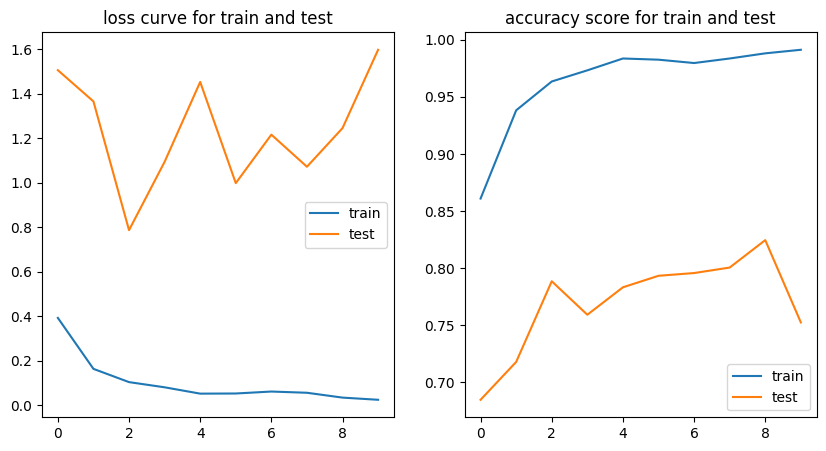

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(result['train_loss'], label= 'train')
plt.plot(result['test_loss'], label= 'test')
plt.title('loss curve for train and test')
plt.legend();
plt.subplot(1,2,2)
plt.plot(result['train_accuracy'], label= 'train')
plt.plot(result['test_accuracy'], label= 'test')
plt.title('accuracy score for train and test')
plt.legend();

# The data is overfitting so i will use a simpler model

# Getting data ready using the helper functions written earlier

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
    ])

train_dataloader, test_dataloader,val_dataloader, class_names= dataloader_function(train_dir= train_dir,test_dir=test_dir,
                                                                                   transform= train_transform,
                                                                                   val_dir= val_dir, batchsize=32, num_worker=4)

In [ ]:
train_dataloader, test_dataloader
#optim= torch.optim.Adam(model.parameters(), lr=0.001)

(<torch.utils.data.dataloader.DataLoader at 0x7fc6cf3c3c40>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc6cf3c3b50>)

In [ ]:
result_2= training_loop(train_dataloader= train_dataloader, test_dataloader= test_dataloader,
                        loss_fn=loss_fn, device=device, optimizer= optimizer,model=model, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

train accuracy: 0.8837121212121212 | train_loss: 0.36752161093884045 | test accuracy: 0.7932692307692307 | test loss: 0.8086191217007581
train accuracy: 0.9330176767676768 | train_loss: 0.19785606356130706 | test accuracy: 0.7091346153846154 | test loss: 1.5419727572454855
train accuracy: 0.9571338383838384 | train_loss: 0.12772323107346892 | test accuracy: 0.7716346153846154 | test loss: 1.2295548611033995
train accuracy: 0.9581755050505051 | train_loss: 0.1137453191034082 | test accuracy: 0.7692307692307693 | test loss: 1.2459320816426322
train accuracy: 0.9729482323232322 | train_loss: 0.0763323357483993 | test accuracy: 0.7764423076923077 | test loss: 1.4373669946552792
train accuracy: 0.9703282828282828 | train_loss: 0.09244910614927196 | test accuracy: 0.7548076923076923 | test loss: 1.4439260955326831
train accuracy: 0.9710227272727272 | train_loss: 0.08418451763379077 | test accuracy: 0.7524038461538461 | test loss: 1.6970499354916124
train accuracy: 0.9763888888888889 | train_